# Classification. Linear models and KNN

In [78]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

В рамках учебного задания был использован датасет из популярного задания на каггле: https://www.kaggle.com/c/titanic/ 

Главная задача - методами ML предсказать вероятность выживания. В моем случае - также и просто "покрутить" данные и некоторые модели.

In [80]:
PATH = "./data/"

In [81]:
train = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

### EDA

Проведу EDA - разведочный анализ данных, позволяющий "освоить" информацию при помощи визуализации. Например, попробуем увидеть связь между полом  и шансом на выживание.

<AxesSubplot:xlabel='Sex,Survived'>

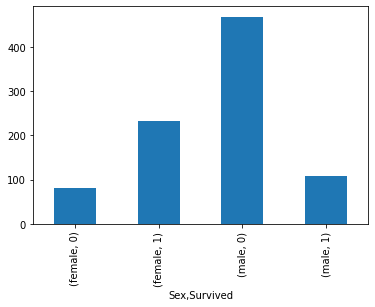

In [82]:
survival = train.groupby(["Sex", "Survived"]).size()
survival.plot(kind = 'bar')




0 - утонул, 1 - спасся, как видим женщин спаслось существенно больше

Попробуем оценить зависимость от возраста. На первом графике - общее распределение по возрастам, на следующих  - таковое отдельно для выживших и не. 

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

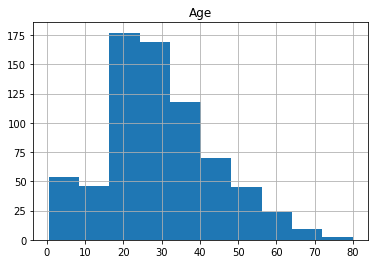

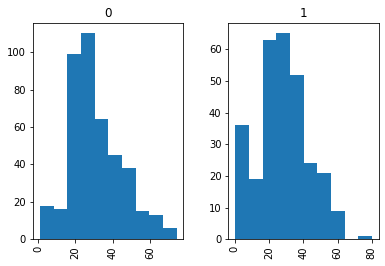

In [83]:
train.hist('Age')
train.hist('Age', by = ['Survived'])


как можно увидеть на третьем график - велика доля спасшихся детей.

В данных есть информация о классе кают и место посадки. Влияет ли это на вероятность выживания?

<AxesSubplot:xlabel='Pclass,Survived'>

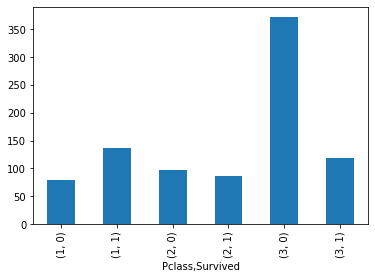

In [84]:
by_class = train.groupby(["Pclass", "Survived"]).size()
by_class.plot(kind = 'bar')



0 - утонул, 1 - спасен. Как видим, пассажиры низшего, 3-го класса имели значительно меньше шансов.

### Modelling

Перейдем к подготовки данных для моделирование. Сначал найдем доли отсутстующих данных.

In [85]:
missing_percentage = round(100*train.isnull().sum()/train.shape[0],1)
print(missing_percentage)


Survived     0.0
Pclass       0.0
Name         0.0
Sex          0.0
Age         19.9
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.0
Cabin       77.1
Embarked     0.2
dtype: float64



Почти у 20% строк отсутствует информация  о возрасте. Как мы видели, эта характеристика, видимо, существенно влияет на вероятность выживания. Могли бы мы предсказать возраст на основании других данных? Для начала посмотрим на подобные строки.


In [86]:
noage = train[train['Age'].isnull()]
noage

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


В столбце с именами присутствуют титулы типа Miss, Mrs, Mr и другие. Они могут коррелировать с возрастной группой. Посмотрим какие вообще титулы существуют.

In [87]:
full_ds = [train, test]
for ds in full_ds:
    ds['Title'] = ds.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

titles = (train['Title'].value_counts())
commons = titles[titles > 10]
commons = list(commons.index)
titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Lady          1
Ms            1
Sir           1
Countess      1
Jonkheer      1
Don           1
Mme           1
Capt          1
Name: Title, dtype: int64

Как можно увидеть - есть несколько популярных титулов, которые можно проассоциировать с определенной возрастной группой. Объединим синонимы, а также сведем редкие значения в одну группу.

In [88]:
for ds in  [train, test]:
    ds.loc[ds.Title.isin(['Mlle', 'Ms']), 'Title']='Miss'
    ds.loc[~ds.Title.isin(commons), 'Title']='Rare'

In [89]:
#посмотрим средний возраст для каждого из титулов
train[['Age']].groupby(train['Title']).mean()

,Age
Title,
Master,4.574167
Miss,21.845638
Mr,32.368090
Mrs,35.898148
Rare,44.608696


И, дополнив недостающие возраста при помощи медианного значения для каждой из групп - представим данную характеристику при помощи возрастных групп.

In [90]:

titles = train['Title'].unique()

for ds in  [train, test]:
    for title in titles:
        title_median_age = ds[ds["Title"] == title]["Age"].median()
        ds.loc[((ds["Title"]==title) & (ds["Age"].isnull()==True)).tolist(),'Age']=title_median_age

    bins = [0,15,25,50,100]
    ds["AgeGroup"]=pd.cut(ds["Age"],bins)

    



In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Name      891 non-null    object  
 3   Sex       891 non-null    object  
 4   Age       891 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    object  
 11  Title     891 non-null    object  
 12  AgeGroup  891 non-null    category
dtypes: category(1), float64(2), int64(4), object(6)
memory usage: 91.6+ KB


In [92]:
# #уберем из датасета данные, которые не будем использовать для предсказания
# train = train.drop(['Name'], ['Cabin'], axis = 1)
# test = test.drop(['Name'], axis = 1)


In [93]:
# train = train.drop( axis = 1)
# test = test.drop(['Cabin'], axis = 1)


In [94]:
#приведем пол и возраст пассажира к цифровым значениям

genders = {"male": 0, "female": 1}
train['Sex']= train['Sex'].map(genders)
test['Sex']= test['Sex'].map(genders)



In [95]:
# embarked = {"S": 1, "C": 2, "Q": 3}

# # train['Embarked'] = train['Embarked'].fillna(value = "C")
# # train['Embarked'] = ds['Embarked'].map(embarked)
# # test['Embarked'] = test['Embarked'].fillna(value = "C", inplace = True)
# # test['Embarked'] = ds['Embarked'].map(embarked)



    


In [96]:
#приведем возрастные группы к цифровым значениям
ages = ds['AgeGroup'].unique()
ages

for ds in [train, test]:
    ds['Age'] = ds['Age'].astype(int)
    ds.loc[ ds['Age'] <= 15, 'Age'] = 0
    ds.loc[(ds['Age'] > 15) & (ds['Age'] <= 25), 'Age'] = 1
    ds.loc[(ds['Age'] > 25) & (ds['Age'] <= 50), 'Age'] = 2
    ds.loc[ ds['Age'] > 50, 'Age'] = 3
    
train['Age'].value_counts()

train = train.drop(['AgeGroup'], axis = 1)
test = test.drop(['AgeGroup'], axis = 1)




In [97]:
# train = train.drop(['Title'], axis = 1)
# test = test.drop(['Title'], axis = 1)


In [98]:
#заполним недостающее место посадки подавляюще популярным значением

for ds in [train, test]:
    ds['Embarked'] = ds['Embarked'].fillna("S")
    
embarked = {"S": 1, "C": 2, "Q": 3}


for ds in [train, test]:
    ds['Embarked'] = ds['Embarked'].map(embarked)

# train["Embarked"].fillna(value = "C", inplace = True)



In [99]:
#уберем из датасета данные, которые не будем использовать для предсказания
train = train.drop(['Name', 'Cabin', 'Title', 'Ticket'],  axis = 1)
test = test.drop(['Name', 'Cabin', 'Title', 'Ticket'], axis = 1)


# train = train.drop(['Ticket'], axis = 1)
# test = test.drop(['Ticket'], axis = 1)



In [100]:
for ds in [train, test]:
    ds['Fare'] = ds['Fare'].fillna(0)


In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    int32  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int64  
dtypes: float64(1), int32(1), int64(5)
memory usage: 24.5 KB


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Данные некоторым образом очищены, сгруппированы, заполнены недостающие значения, удалены колонки, которые не будут использоваться в предсказании.

Перейдем к главному: попробуем обучить разные модели (я использую KNN и Logistic Regression) и оценим их качество испольуя метрику accuracy.



In [102]:
y = train['Survived']


In [103]:
from sklearn.model_selection import train_test_split


y = train["Survived"]
X = train.drop(['Survived'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)



In [104]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)

print('KNN accuracy: ', acc_knn)

KNN accuracy:  80.45


In [105]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)

print('LogReg accuracy', acc_logreg)

LogReg accuracy 79.33


Конечно, для улучшения качества моделей стоило бы еще поэкспериментировать с feature engeneering, разобраться с гиперпараметрами, но на данном этапе считаю выполненными задачи попробовать в учебных целях предварительный анализ данных, конструирование признаков, и непосредственно использование и оценку моделей машинного обучения.

Далее сформирую файл для отправки на каггл.

In [106]:
## your code

ids = test.index
final_predictions = knn.predict(test)

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': final_predictions })
output.to_csv('submission.csv', index=False)

